In [1]:
import urllib.request
url ='https://raw.githubusercontent.com/Condor-Instruments/pyCosinor/master/cosinor.py'
filename = 'cosinor.py'
urllib.request.urlretrieve(url, filename)
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import cosinor as cs
init_notebook_mode(connected = True)

# Cosinor Analysis

Most of the time, when analyzing the rhythmicity of some given dataset it is hard to objectively compare results. There are several different analyses in the literature used for calculating objective and comparable parameters from raw data and cosinor analysis is one of the most used in chronobiology field. This analysis can be performed by basically fitting a cosine wave on the data. It can be easily done numerically, however, sometimes it won't be able to convege to a stabel result. Nonetheless, there are analytical solutions for such problems as presented by Cornelissen (2014) in the paper "Cosinor-based rhythmometry" there are much more stable. Following, there are a few examples of analysing some actigraphy data using cosinor analysis.

### Helper functions

We will be using some helper functions already explained in the Loading Data and Actogram tutorials. 

In [2]:
def actigraphy_load_data(filename):
    f = open(filename, "r")
    count = 0
    while count < 50:
        count += 1

        # Get next line from file
        line = f.readline()
        if '+-------------------------------------------------------+' in line:
            break
    df = pd.read_csv(filename, delimiter = ';', header = count, parse_dates = False)
    df['DATE/TIME'] = pd.to_datetime(df['DATE/TIME'], format = '%d/%m/%Y %H:%M:%S')
    df.set_index( df['DATE/TIME'], inplace = True)
    return df   

def actigraphy_select_period(start_date, end_date):
    index = np.logical_and(df.index >= start_date, df.index < end_date)
    filtered_df = df[index]
    return filtered_df


def actigraphy_split_by_day(df, start_hour = 0):
    ldays = []
    ldays_ref = []
    
    #First day is the start of the day of the first Epoch
    sdate = pd.Timestamp(year = df.index[0].year, month = df.index[0].month, day = df.index[0].day)
    if(df.index[0].hour <= start_hour):
        sdate = sdate - pd.Timedelta(hours = start_hour) 
    else:
        sdate = sdate + pd.Timedelta(hours = start_hour)         
    
    while sdate < df.index[-1]:
        day = np.logical_and(df.index >= sdate, df.index < sdate + pd.Timedelta(hours = 24))
        ldays.append(df[day])
        ldays_ref.append(pd.Timestamp(year = sdate.year, month = sdate.month, day = sdate.day))
        sdate += pd.Timedelta(hours = 24)
        
    return ldays, ldays_ref


def rescale(x, min_val, max_val):
    resc = (x - min_val)/(max_val - min_val)
    return resc

def actigraphy_double_plot_actogram(df, column):
    max_val = max(df[column])*1.1
    min_val = min(df[column])
    if min_val > 0:
        min_val = min_val*0.9
    
    #First day is the start of the day of the first Epoch
    ldays, ldays_ref = actigraphy_split_by_day(df) 
    fig = go.Figure()    
    i = 0
    for i in range(len(ldays)-1):
        d1 = ldays[i]
        d2 = ldays[i+1]
        x1 = d1.index.hour + d1.index.minute/60.0 + d1.index.second/3600.0
        x2 = d2.index.hour + d2.index.minute/60.0 + d2.index.second/3600.0 + 24.0
        x = np.append(x1,x2)
        y = np.append(d1[column],d2[column])
        y = (i+1)-rescale(y, min_val, max_val)
        fig.add_trace(go.Scatter(x=x,y=y,line=dict(color='royalblue')))
        i +=1
    d1 = ldays[-1]
    x = d1.index.hour + d1.index.minute/60.0 + d1.index.second/3600.0
    y = d1[column]
    y = (i+1)-rescale(y, min_val, max_val)
    fig.add_trace(go.Scatter(x=x,y=y,line=dict(color='royalblue')))
    
    
    fig.update_yaxes(range=[len(ldays), 0])    
    fig.update_layout(showlegend=False)
    fig.update_xaxes(tick0=0, dtick=2)
    fig.update_layout(height=len(ldays)*70)

    
    return fig

#### Loading Data

We will start here loading some actigraphy data saved with ActStudio using the helper function defined previously. We will also filter the period to remove the beginning of the data in which the user was not using the ActTrust device.

In [3]:
filename = "Example_Log.txt"
url ='https://github.com/Condor-Instruments/actigraphy-tutorials-sample/blob/master/Example_Log.txt?raw=true'
urllib.request.urlretrieve(url, filename)

df = actigraphy_load_data(filename)

start_date = pd.Timestamp('2015-12-26 00:00:00')
end_date = df.index[-1]
df = actigraphy_select_period(start_date,end_date)

## Whole Period Cosinor Analysis

The most comon use of a cosinor analysis is to fit a single cosine wave on all the data collected. Basically this fitted cosinor will represent an average cicle of the subject. Following there is an example using Condor's implementation of the cosinor analysis.

In [4]:
epoch = (df.index - pd.Timestamp(1970,1,1)).total_seconds()
T = 24*60*60
cos = cs.Cosinor(epoch,df['PIM'],T,0.05)
cos.fit()
cos.printParam(g = 0)

---Parameter estimation---
Mesor: 2484.536907091433
Amplitude: 1801.123327678361
Acrophase: -3.4108131785611335 (13.028346655943613 hours)
(Gamma: -479.0629995283057  Beta: -1736.2441890443044)



In [5]:
cosine_estimate = cos.M + cos.Amp*np.cos(cos.w*epoch + cos.phi)

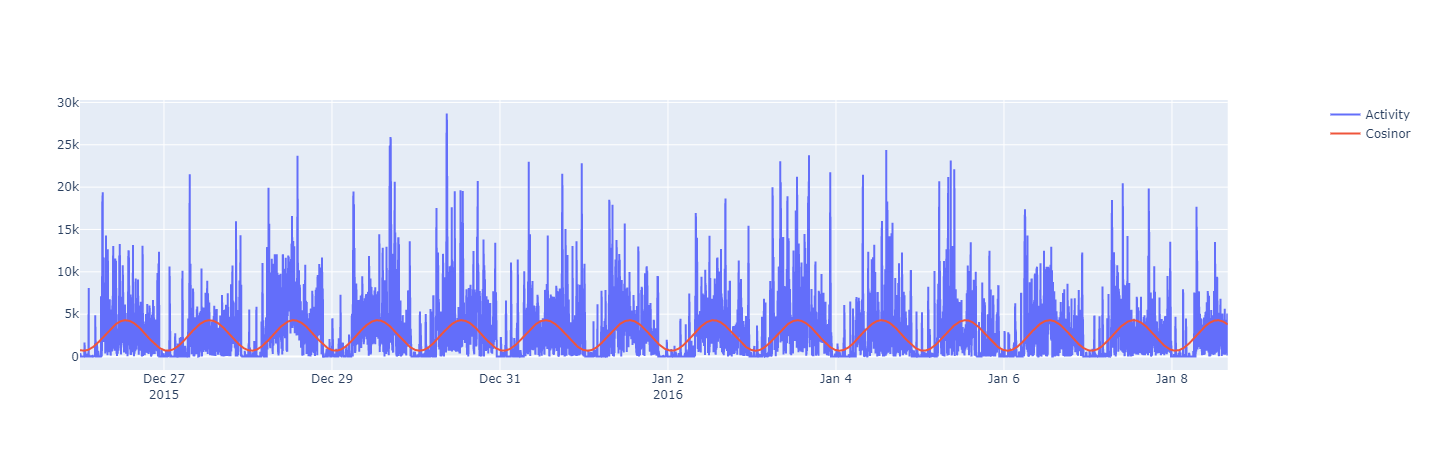

In [6]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df.index, y=df['PIM'], name = 'Activity'), secondary_y=False)
fig.add_trace(go.Scatter(x=df.index, y=cosine_estimate, name = 'Cosinor'), secondary_y=False)

## Daily Cosinor Analysis

Despite the fact that the whole period cosinor is great to access the pattern of a given subject, it will express an average parameter. In fact, if we are dealing with subjects with patterns with a lot of variability, the resulting number won't describe well the reality. For a better understanding on these cases, a daily cosinor might be useful. Following an example of such use.

In [7]:
def actigraphy_calculate_daily_acrophase(df, channel):
    ldays, ldays_ref = actigraphy_split_by_day(df, start_hour = 0)
    T = 24*60*60
    cosinor_phase = []
    cosinor_phase_ci = []
    cosinor_phase_error = []
    i = 0
    for data in ldays:
        timestamp = (data.index - pd.Timestamp(1970,1,1)).total_seconds()
        cosFit = cs.Cosinor(timestamp,data[channel],T,0.05)
        cosFit.fit()
        cosinor_phase.append(cosFit.phi)
        cosinor_phase_ci.append(np.abs(cosFit.CI_phi[0]-cosFit.phi))
        
    acrophase = (2*np.pi-np.array(cosinor_phase))*12/np.pi
    acrophase_confidence_interval = (np.array(cosinor_phase_ci))*12/np.pi
    ret_df = pd.DataFrame()
    ret_df[channel+'_ACROPHASE'] = acrophase
    while (ret_df[channel+'_ACROPHASE'] < 0).any():
        ret_df[channel+'_ACROPHASE'] += 24
    ret_df[channel+'_ACROPHASE'] = ret_df[channel+'_ACROPHASE']%24
    ret_df[channel+'_ACROPHASE_CI'] = acrophase_confidence_interval
    ret_df['DAY'] = ldays_ref
    ret_df.set_index(ret_df['DAY'], inplace = True)
    ret_df.drop(columns=['DAY'], inplace = True)
    return ret_df

### Calculating the daily acrophase

In [8]:
acro_df = actigraphy_calculate_daily_acrophase(df, 'PIM')

### Ploting the data on a double plot actogram

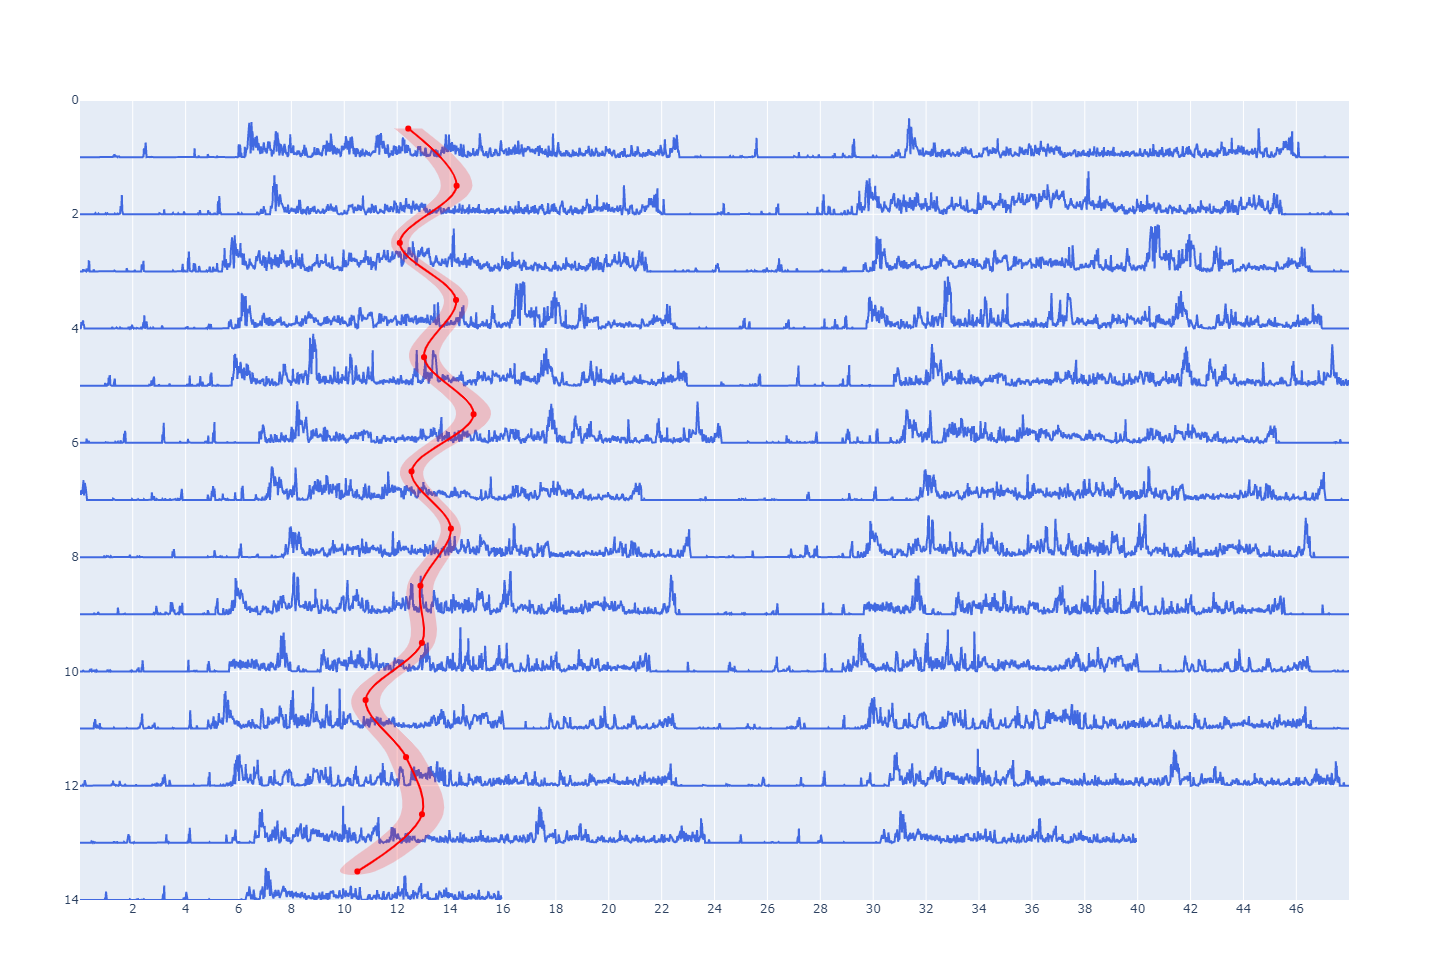

In [9]:
acrophase = acro_df['PIM_ACROPHASE']
acrophase_confidence_interval = acro_df['PIM_ACROPHASE_CI']

fig = actigraphy_double_plot_actogram(df, 'PIM')
fig.add_trace(go.Scatter(x=acrophase[0:],y=np.array(range(len(acrophase)))[0:]+0.5,line=dict(color='red'),line_shape='spline'))
x = np.array(range(len(acrophase)))[0:]+0.5
x_rev = x[::-1]
y1_upper = acrophase[0:]+acrophase_confidence_interval[0:]
y1_lower = acrophase[0:]-acrophase_confidence_interval[0:]
fig.add_trace(go.Scatter(
    x=np.concatenate((y1_upper,y1_lower[::-1])),
    y = np.concatenate((x,x_rev)),
    fill='toself',
    fillcolor='rgba(255,0,0,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Fair',
    line_shape='spline'
))